In [1]:
mode = "png"

import matplotlib

font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib
from matplotlib import pyplot as plt

In [2]:
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(root='data/clintox', name='ClinTox')
print(f'Dataset: {dataset}\nNumber of molecules/graphs: {len(dataset)}\nNumber of classes: {dataset.num_classes}')

Dataset: ClinTox(1484)
Number of molecules/graphs: 1484
Number of classes: 2


/Users/alex/mambaforge/envs/graphstatsbook/lib/python3.12/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) a

In [3]:
mols = dataset[26], dataset[83]
for m in mols:
    print(m.smiles)

C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@]2([C@H]([C@@H]([C@H](O2)CO)O)O)CO)O)O)O)O
C1[C@@H]([C@H]([C@@H]([C@H]([NH+]1CCO)CO)O)O)O


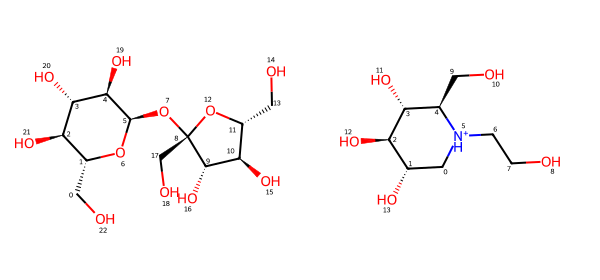

In [4]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

smiles = [Chem.MolFromSmiles(m.smiles) for m in mols]
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addAtomIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [5]:
for i,m in enumerate(mols):
    print(f'Molecule {i+1}: Number of atoms={m.x.shape[0]}, Features per atom={m.x.shape[1]}')

Molecule 1: Number of atoms=23, Features per atom=9
Molecule 2: Number of atoms=14, Features per atom=9


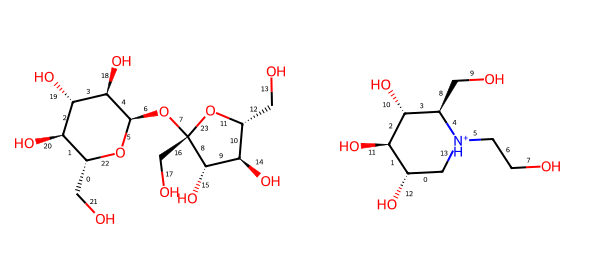

In [6]:
d2d = rdMolDraw2D.MolDraw2DSVG(600,280,300,280)
d2d.drawOptions().addBondIndices = True
d2d.DrawMolecules(smiles)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [7]:
import numpy as np

_process = lambda x: [e[0] for e in np.split(x, 2)]
def adj_from_edgelist(molecule):
    """
    A function that takes a molecule edgelist and produces an adjacency matrix.
    """
    # the number of nodes is the number of atoms (rows of .x attribute)
    n = molecule.x.shape[0]
    # the adjacency matrix is n x n
    A = np.zeros((n, n))
    edgelist = m.edge_index.numpy()
    # loop over the edges e_k, and for each edge, unpack the 
    # nodes that are incident it. for this pair of nodes, 
    # change the adjacency matrix entry to 1
    for e_k, (i, j) in enumerate(zip(*_process(edgelist))):
        A[i, j] = 1
    return A

/Users/alex/mambaforge/envs/graphstatsbook/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


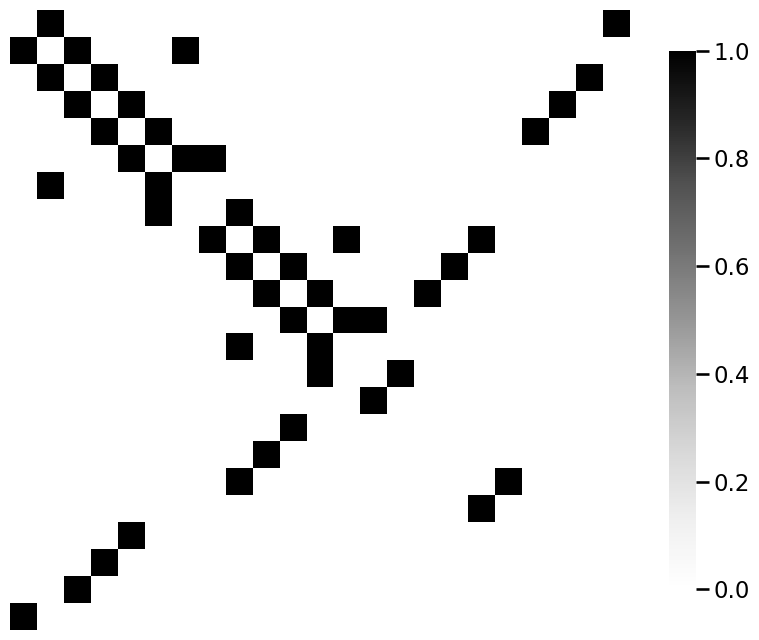

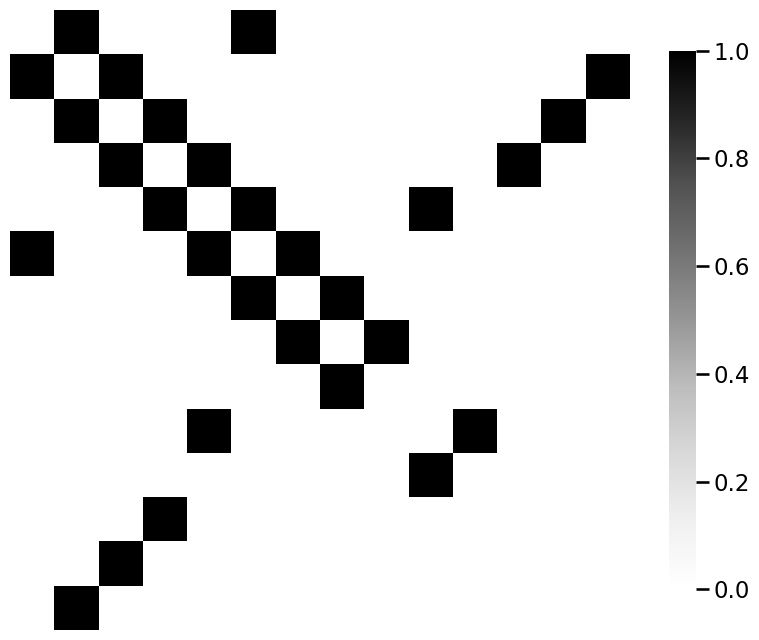

In [8]:

from graphbook_code import heatmap

for m_i, m in enumerate(mols):
    A = adj_from_edgelist(m)
    heatmap(A)

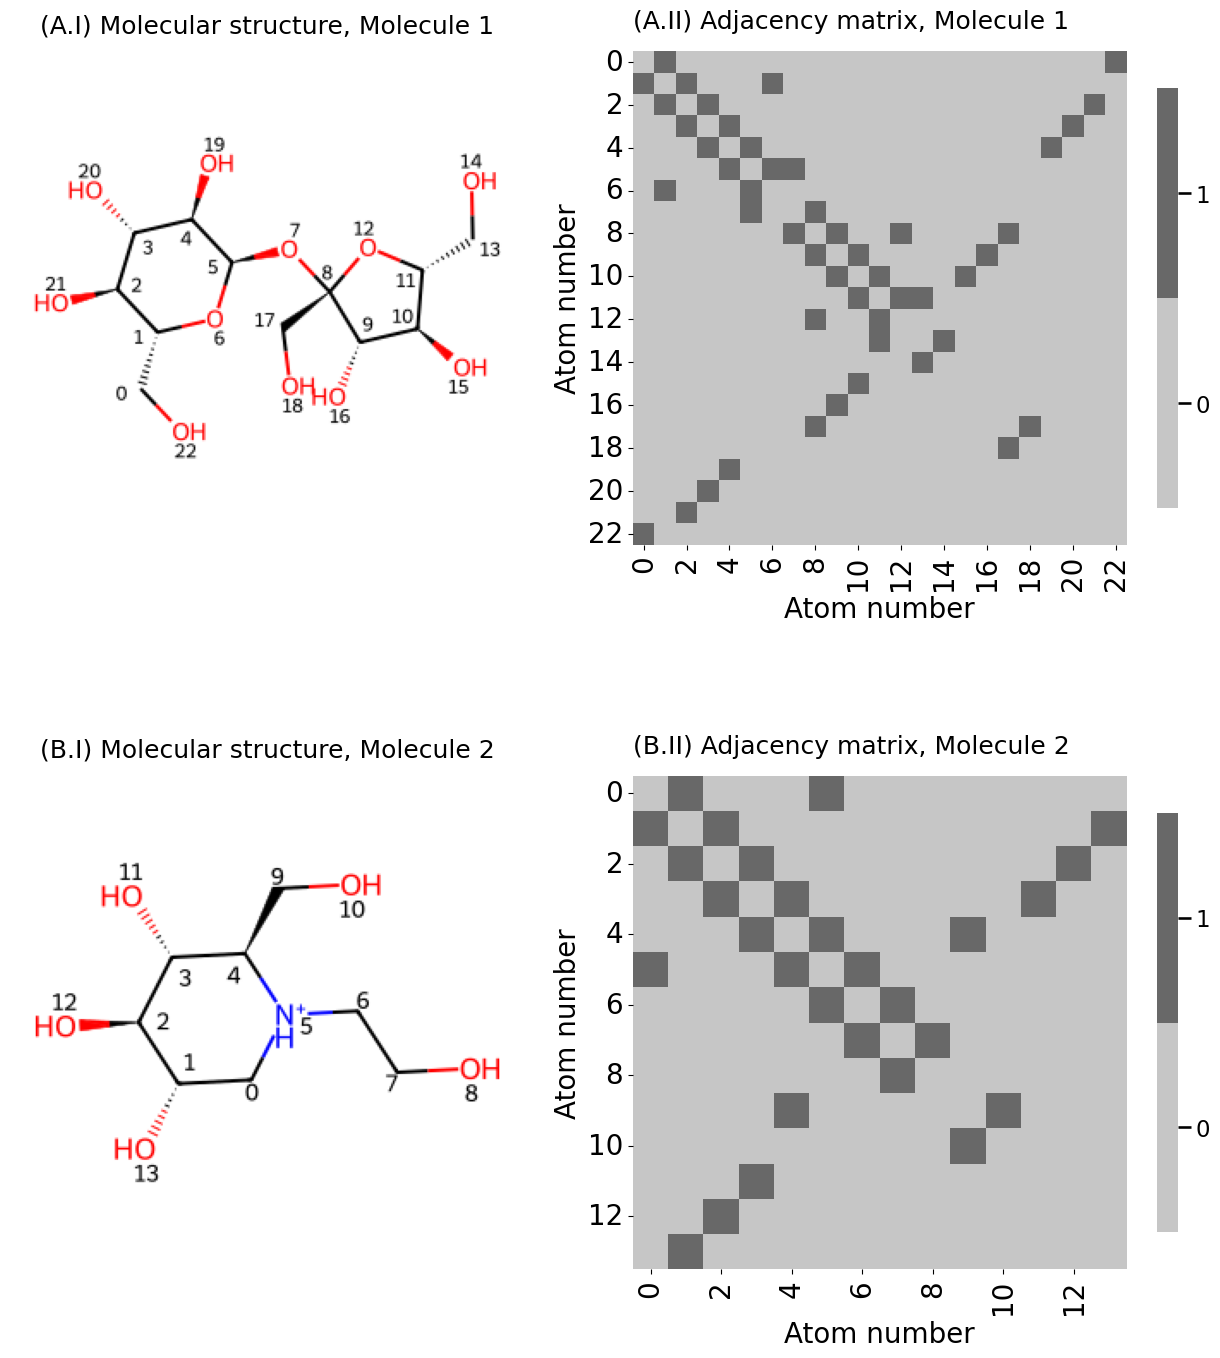

In [9]:
from PIL import Image
import os

fig, axs = plt.subplots(2, 2, figsize=(13, 15), gridspec_kw={"width_ratios": [1, 1.2]})

plot_titles = [[f"({x:s}.{y:s}" for y in [f"I) Molecular structure, {z:s}", f"II) Adjacency matrix, {z:s}"]] for x, z in zip(["A", "B"], ["Molecule 1", "Molecule 2"])]
title_left = ["Molecule 1", "Molecule 2"]
for i, m in enumerate(mols):
    d2d = rdMolDraw2D.MolDraw2DCairo(300,300)
    options = d2d.drawOptions()
    options.addAtomIndices = True; options.minFontSize = 14; options.annotationFontScale = 0.8
    
    d2d.DrawMolecule(Chem.MolFromSmiles(m.smiles))
    d2d.FinishDrawing()
    png_data = d2d.GetDrawingText()
    
    # save png to file
    png_fname = f'mol{i:d}.png'
    with open(png_fname, 'wb') as png_file:
        png_file.write(png_data)
    axs[i][0].imshow(Image.open(png_fname))
    axs[i][0].set_title(plot_titles[i][0], fontsize=18)
    axs[i][0].axis("off")

    A = adj_from_edgelist(m)
    tick_range = range(0, np.ceil(A.shape[0] / 2).astype(int))
    xticks = yticks = [2 * i + 0.5 for i in tick_range]
    xticklabels = yticklabels = [f"{2 * i}" for i in tick_range]
    heatmap(A.astype(int), ax=axs[i][1], xticks=xticks, xticklabels=xticklabels,
            yticks=yticks, yticklabels=yticklabels, shrink=0.6,
            title=plot_titles[i][1], xtitle="Atom number", ytitle="Atom number")

fig.tight_layout()

os.makedirs("Figures", exist_ok=True)
fname = "molecule_ex"
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))

In [10]:
import torch
# for notebook reproducibility
# torch.manual_seed(12345)

dataset = dataset.shuffle()

train_dataset = dataset[:1216]
test_dataset = dataset[1216:]

print(f'Number of training networks: {len(train_dataset)}')
print(f'Number of test networks: {len(test_dataset)}')

Number of training networks: 1216
Number of test networks: 268


In [11]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print(f'Number of networks in the current batch: {data.num_graphs}')
    print(data)
    break

Step 1:
Number of networks in the current batch: 64
DataBatch(x=[1852, 9], edge_index=[2, 3936], edge_attr=[3936, 3], smiles=[64], y=[64, 2], batch=[1852], ptr=[65])


In [13]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

# torch.manual_seed(12345)
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes, bias=False)

    def forward(self, x, edge_index, batch):

        # 1. Obtain node embeddings via convolutional layers
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer to produce network embedding
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a prediction classifier to the network embedding
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=False)
)


In [15]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x.float(), data.edge_index, data.batch)  # Perform a single forward pass.
        # Handle a pyg bug where last element in batch may be all zeros and excluded in the model output.
        # https://github.com/pyg-team/pytorch_geometric/issues/1813
        num_batch = out.shape[0]
        loss = criterion(out, data.y[:num_batch, 0].long())  # Compute the loss.
        
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
        model.eval()

        correct = 0
        for data in loader:  # Iterate in batches over the training/test dataset.
            out = model(data.x.float(), data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            # Debugging prints
            correct += int((pred == data.y[:, 0]).sum())  # Check against ground-truth labels.
        return correct / len(loader.dataset)  # Derive ratio of correct predictions.

R = 10  # number of epochs
for epoch in range(0, R):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 001, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 002, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 003, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 004, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 005, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 006, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 007, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 008, Train Acc: 0.9317, Test Acc: 0.9440
Epoch: 009, Train Acc: 0.9317, Test Acc: 0.9440


In [16]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 1216
Test dataset size: 268


In [17]:
fig.tight_layout()

fname = ""
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))

In [18]:
fig.tight_layout()

fname = ""
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))

In [19]:
fig.tight_layout()

fname = ""
if mode == "png":
    fig.savefig("Figures/{}.{}".format(fname, mode))
    fig.savefig("Figures/{}.svg".format(fname))
else:
    fig.savefig("Figures/{}.svg".format(fname))